In [2]:
import torch
import torchvision
import tqdm
import einops

def get_dataloader():
    tf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)

dataloader = get_dataloader()
for batch in dataloader:
    images, labels = batch
    break

In [3]:
# patching = Rearrange('b c (p1 h) (p2 w) -> b (p1 p2) c h w', p1 = 4, p2 = 4)
# patchs = patching(images)

# patchs = einops.rearrange(images, 'b c (p1 h) (p2 w) -> b (p1 p2) c h w', p1 = 4, p2 = 4)
patchs = einops.rearrange(images, 'b c (h p1) (w p2) -> (b h w) c p1 p2', p1 = 4, p2 = 4)

In [15]:
print(patchs.shape)

torch.Size([6272, 1, 4, 4])


(-0.5, 27.5, 27.5, -0.5)

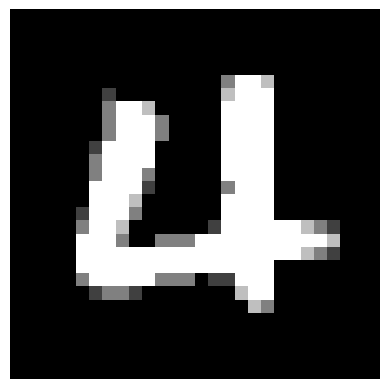

In [16]:
from matplotlib import pyplot as plt

plt.imshow(images[0][0], cmap='gray')
plt.axis("off")

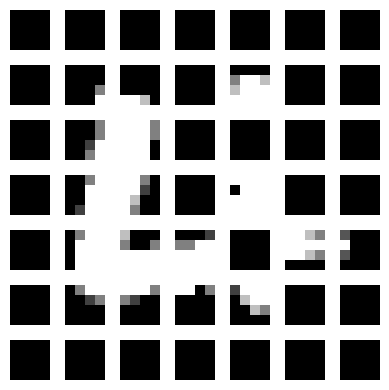

In [17]:
fig, axes = plt.subplots(7, 7, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(patchs[i].squeeze(0), cmap='gray')
    ax.axis("off")
plt.tight_layout()
plt.show()

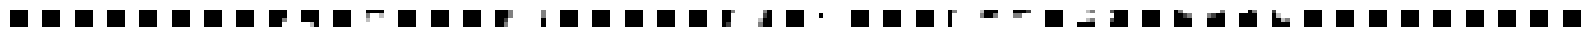

In [18]:
fig, axes = plt.subplots(1, 49, figsize=(16, 16*16))
for i, ax in enumerate(axes.flat):
    ax.imshow(patchs[i].squeeze(0), cmap='gray')
    ax.axis("off")
plt.tight_layout()
plt.show()

---

In [37]:
from patch_vae import VAE
import torch

net = VAE(latent=2, num_codebook=512).to('mps')
net.load_state_dict(torch.load('patch_vae.pth'))
net.eval()

import torch
import torchvision
import tqdm
import einops

def get_dataloader():
    tf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)

dataloader = get_dataloader()
for batch in dataloader:
    images, labels = batch
    break

In [52]:
images = images.to('mps')
patchs = einops.rearrange(images, 'b c (h p1) (w p2) -> (b h w) c p1 p2', p1 = 4, p2 = 4)
with torch.no_grad():
    x_h, _ = net(patchs)
x_h = x_h.to('cpu')

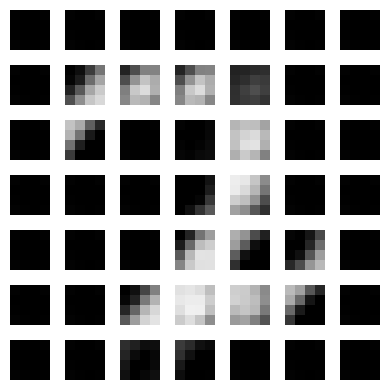

In [42]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(7, 7, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_h[i].squeeze(0).numpy(), cmap='gray', vmin=0, vmax=1)
    ax.axis("off")
plt.tight_layout()
plt.show()

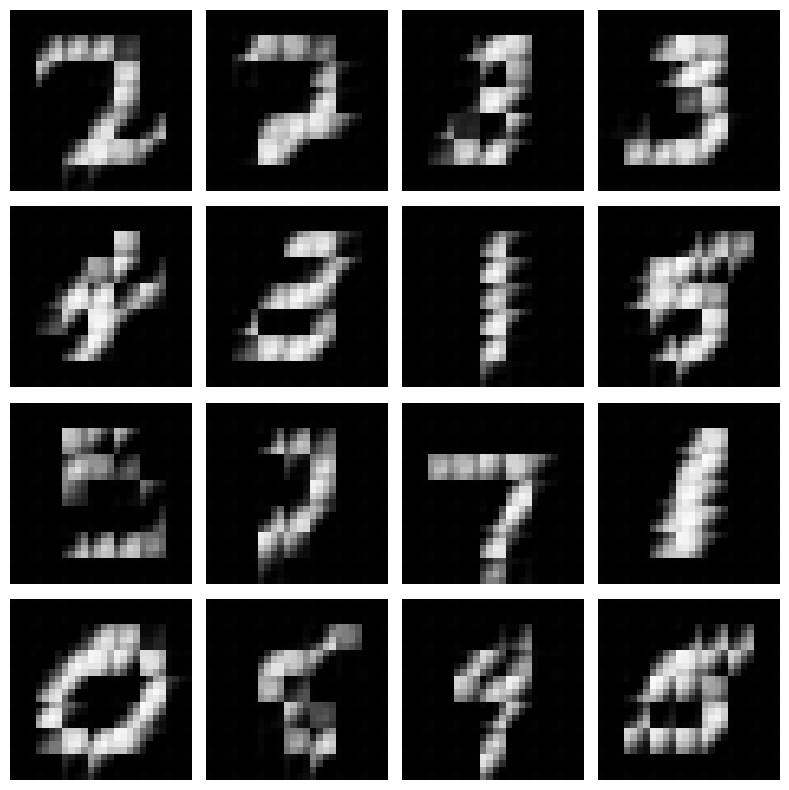

In [54]:
def unpatch(x, grid_size=(7, 7), batch_size=128):
    batch_size_num_patches, c, ph, pw = x.size()
    x = x.view(batch_size, -1, c, ph, pw)
    # x shape is batch_size x num_patches x c x jigsaw_h x jigsaw_w
    batch_size, num_patches, c, ph, pw = x.size()
    assert num_patches == grid_size[0] * grid_size[1]
    x_image = x.view(batch_size, grid_size[0], grid_size[1], c, ph, pw)
    output_h = grid_size[0] * ph
    output_w = grid_size[1] * pw
    x_image = x_image.permute(0, 3, 1, 4, 2, 5).contiguous()
    x_image = x_image.view(batch_size, c, output_h, output_w)
    return x_image

xx = unpatch(x_h)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(xx[i].squeeze(0).numpy(), cmap='gray', vmin=0, vmax=1)
    ax.axis("off")
plt.tight_layout()
plt.show()

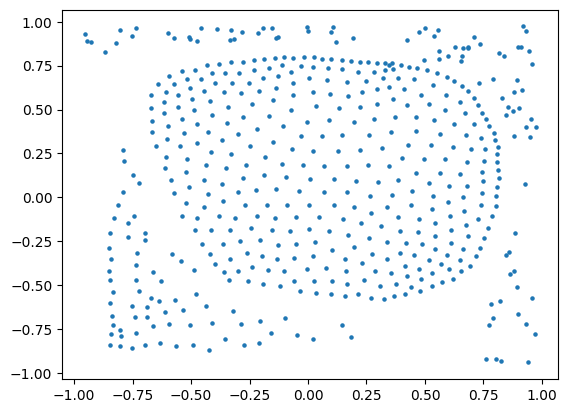

In [29]:
codebook = net.vq.embedding.weight.data.to('cpu')
plt.scatter(codebook[:, 0],codebook[:, 1], marker='o', s=5)